In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import io
import math
from PIL import Image
from matplotlib.colors import LogNorm

In [2]:
def rand_positive_spanning_set(alpha, n):
#     create positive spanning sets (set of vectors whos positive span is R n)
    delta = round(1/math.sqrt(alpha))
#     create lower triangular matrix
    L = np.diag(delta*random.choices([-1,1], k=n))
    
#     create lower components of L
    for i in range(1,n-1):
        for j in range(1,i-1): 
            L[i,j] = np.random.randint(-delta+1 ,delta-1)
            
#     rows and columns of L are then randomly permuted to obtain a matrix D
    D = L[np.random.permutation(n),:]
    D = D[:, np.random.permutation(n)]
    
#     add one additional direction
    D = np.hstack((D ,np.array([-D.sum(axis=0)]).T))
    return [D[:,i] for i in range(n+1)]

In [3]:
class mesh_adaptive_direct_search:
    def __init__(self, f, X, epsilon):
        self.f = f
        self.X = X
        if not isinstance(self.X, np.ndarray):
            self.X = np.array([X])
        self.epsilon = epsilon
        
        self.y = f(X)
        self.alpha = 1 
        self.n = len(X)

        self.vector = []
        self.steps = [] # list of x values
        
    def optimize(self):
        while self.alpha > self.epsilon:
            improved = False
            
            vectors = rand_positive_spanning_set(self.alpha, self.n)
            res = [list(self.X + self.alpha * item) for item in vectors]
            self.steps.append(self.X)
            self.vector.append(res)

            for (i,d) in enumerate(vectors):
                x_next = self.X + self.alpha * d
                y_next = self.f(x_next)
    
#                 queries a new design point along the accepted direction
                if y_next < self.y:
                    self.X, self.y, improved = x_next, y_next, True
                    x_next = self.X + 3 * self.alpha * d
                    y_next = self.f(x_next)
                    if y_next < self.y:
                        self.X, self.y = x_next, y_next
                    break
                    
#            update step size                
            if  improved == True:
                self.alpha = min(4* self.alpha, 1) 
            else: self.alpha = self.alpha/4

                
        return self.X

In [7]:
def visualize_func(func,x_range, y_range, global_minima):
    Xs = np.linspace(*x_range, 1000)
    Ys = np.linspace(*y_range, 1000)
    X, Y = np.meshgrid(Xs, Ys)

    Z = func((X, Y))

    # Plot countour
    plt.contour(X, Y, Z, levels=np.linspace(Z.min(), Z.max(), 10))
    plt.scatter(global_minima[0], global_minima[1], color='red')
    plt.colorbar()

In [8]:
def visualize_single(step, vector, opacity = False):
    if opacity == False:
        plt.scatter(step[0],step[1], color='black', s=10)
        for item in vector:
            plt.scatter(item[0],item[1],color="black",s=10)
            x_values = [step[0], item[0]]
            y_values = [step[1], item[1]]
            plt.plot(x_values, y_values, color = 'black')
    else:
        plt.scatter(step[0],step[1],color = "blue", s=15, alpha=0.3)
    for item in vector:
        plt.scatter(item[0],item[1],color="black", alpha=0.1,s=10)
        x_values = [step[0], item[0]]
        y_values = [step[1], item[1]]
        plt.plot(x_values, y_values, color = 'black', alpha=0.3)

In [9]:
def visualize_final(steps, vectors, prev_step, prev_vector):
    visualize_func(Wheeler,(0,3),(0,3),global_minima)
    visualize_single(steps,vectors,False)
    visualize_single(prev_step,prev_vector,True)
    plt.show()

In [42]:
def Wheeler(X):
    a = 1.5
    x = X
    return -np.exp(-(x[0]*x[1]-a)**2-(x[1]-a)**2)

startingX = np.array([2, 1])

global_minima = np.array([1, 1.5])

In [43]:
mads = mesh_adaptive_direct_search(f=Wheeler, X=startingX, epsilon = 0.01)

mads.optimize()

array([1. , 1.5])

In [44]:
vectors = np.array(mads.vector)
steps = np.array(mads.steps)

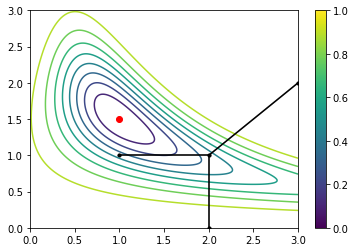

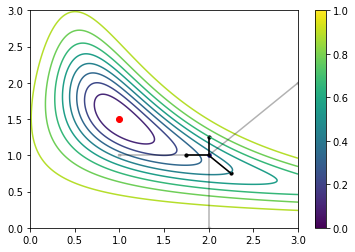

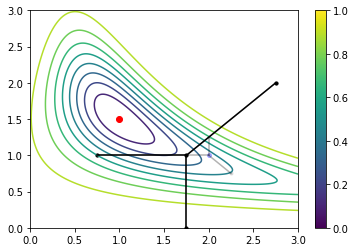

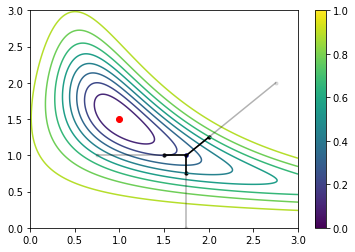

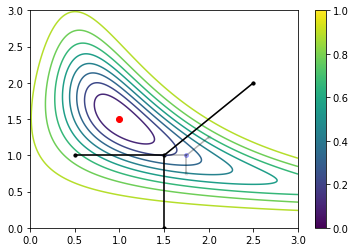

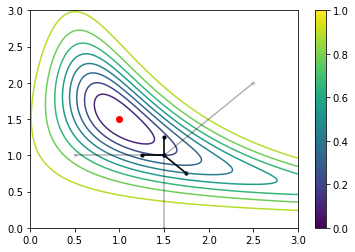

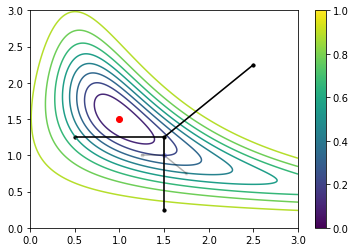

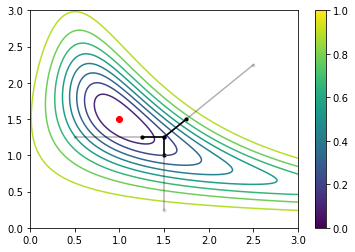

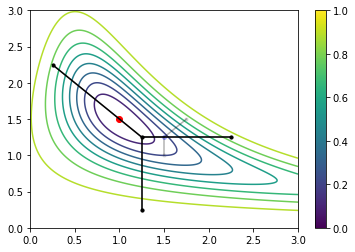

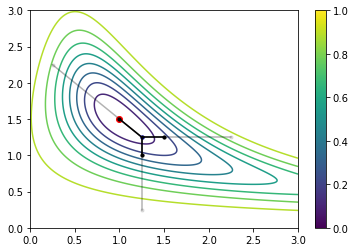

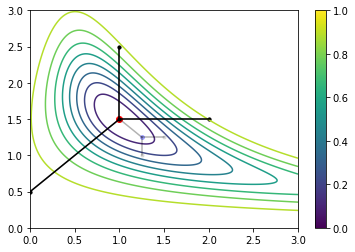

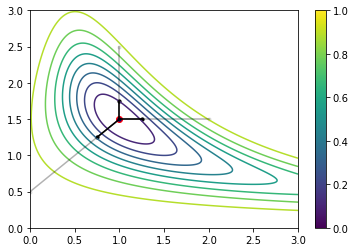

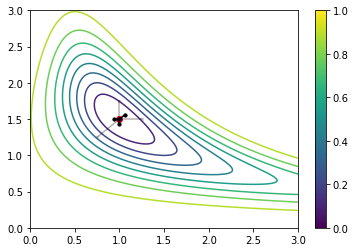

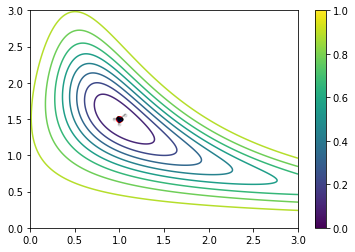

In [45]:
for i in range(0, len(vectors),1):
    if i == 0:
        visualize_func(Wheeler,(0,3),(0,3),global_minima)
        visualize_single(steps[i], vectors[i], False)
        plt.show()
    else:
        visualize_final(steps[i], vectors[i], steps[i-1], vectors[i-1])

In [46]:
def visualize_gif(steps, vectors, prev_step, prev_vector,frames):
    visualize_func(Wheeler,(0,3),(0,3),global_minima)
    
    visualize_single(steps,vectors,False)
    visualize_single(prev_step,prev_vector,True)    
    
    # Save GIF frame to buffer
    buffer = io.BytesIO()
    plt.savefig(buffer, format='png')
    plt.close()
    buffer.seek(0)
    
    # Load and store frame using PIL
    frame = Image.open(buffer)
    frames.append(frame)
       
    return frames

In [47]:
frames = []
for i in range(0,len(vectors),1):
    if i == 0:
        visualize_func(Wheeler,(0,3),(0,3),global_minima)
        visualize_single(steps[i], vectors[i], False)
        
        buffer = io.BytesIO()
        plt.savefig(buffer, format='png')
        plt.close()
        buffer.seek(0)

        # Load and store frame using PIL
        frame = Image.open(buffer)
        frames.append(frame)
    else:
        visualize_gif(steps[i], vectors[i], steps[i-1], vectors[i-1],frames)
frames[0].save(fp='mesh_adaptive_direct_search.gif', format='GIF',
               append_images=frames, save_all=True, duration=800, loop=0)